In [ ]:
# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Toggle ON/OFF raw code cells."></form>''')

## The pipeline for all images

Let us now assemble all steps above in a pipeline, to be run for all and each image in the CS82 archive.

For each image, the pipeline should:
* Save the total number of objects (NUMOBJ_GROSS)
* Filter out objects with `FLAGS`>0
* Save the number of remaining objects (NUMOBJ_NET)
* Create the field coverage plot (`ALPHA_J2000`,`DELTA_J2000`)
* Create the `FLAGS` histogram
* Fit the log-curve with `{MAG,MAGERR}_{AUTO,MODEL,PSF,APER,SPHEROID,HYBRID,BEST,PETRO,ISO,ISOCOR}`
* Compute magnitude limit for SNR=5 and SNR=2
 * using the fit curve
 * using the boxplots
 

* For each image we want to create a table with all the limiting magnitude mesaurements.
For example:

mag_type | SNR | MAG_ERROR | MAG_LIMIT_CURVEFIT | MAG_LIMIT_BOXPLOT
-------- | --- | --------- | ------------------ | -----------------
AUTO     | 5   | 0.2       | 24.44              | 24.59
AUTO     | 2   | 0.5       | 25.69              | None
BEST     | 5   | 0.2       | 24.47              | 24.6
BEST     | 2   | 0.5       | 25.71              | None
PSF      | 5   | 0.2       | 24.95              | 24.82\*
PSF      | 2   | 0.5       | 25.99              | None
... | | | |
This table should be named ${tilename}_magLimits.csv

* For each image we want to create the following plots for each Magnitude type:
 * scatter *Mag .vs. MagErr*, with the fit curve and the annotations for SNR={2,5}
 * boxplot *MagErr .by. Mag*, with the marker lines for SNR={2,5}
 * footprint *RA .vs. Dec*
 * Histogram *FLAGS*

In [ ]:
import matplotlib
# matplotlib.use('Agg')

# import seaborn
# seaborn.set()

import astropy
import pandas
import numpy
import scipy

In [ ]:
class Plots:
    '''
    Manage data source and plot creation
    '''
    @staticmethod
    def scatter(x, y, vlines=None, fit_func=None, title=None, savefig=False):
        import pandas
        df = pandas.DataFrame({x.name:x, y.name:y})
        
        def scatter_mags(x,y,df):
            from matplotlib import pyplot as plt
            plt.scatter(df[x.name], df[y.name], marker='.', alpha=0.1, lw=None)
            plt.xlabel(x.name)
            plt.ylabel(y.name)
            plt.title(title)
            return plt

        plt = scatter_mags(x,y,df)
        plt.hold(True)

        def fit_curve(x,y,fit_func):
            import numpy as np
            from scipy.optimize import curve_fit
            popt,pcov = curve_fit(fit_func, x, y)
            x = np.linspace(x.min(),x.max(),100)
            y = fit_func(x,*popt)
            return x,y,popt

        if fit_func != None:
            x_fit, y_fit, popt = fit_curve( df[x.name], df[y.name], fit_func )
            plt.plot( x_fit, y_fit, linestyle='solid', color='red', lw=1 )

        vlines_intersec = None
        if vlines:
            vlines_intersec = []
            for x_line in vlines:
                y_val = fit_func(x_line,*popt)
                vlines_intersec.append(y_val)
                
                plt.axvline(x_line, color='red', linestyle='dotted')

                _lbl = ' {:.2f}, {:.2f} '.format(x_line,y_val)
                plt.text(x_line+0.01, y_val-5, _lbl, bbox=dict(facecolor='white', alpha=0.9))

        del df
        plt.hold(False)
        fig = plt.gcf()
        return fig,vlines_intersec
    
    @staticmethod
    def boxplot(column, by, hlines, nbins=20, fit_func=None, savefig=False):
        '''
        Boxplot distributions of 'column' splitted by column 'by' in 'nbins'
        
        'hlines' is a list of values within 'column' limits, where 'column'
        should be annotated.
        '''
        import pandas
        df = pandas.DataFrame({column.name:column, by.name:by})
        
        bin_categories,bins = pandas.qcut(df[by.name], nbins, retbins=True, precision=2)
        bincol = '_'+by.name+'_'
        df[bincol] = bin_categories

        from matplotlib import pyplot as plt
        plt.hold(True)
        ax = df.boxplot(column.name,by=bincol, rot=90, sym='*')
        
        # ---
        def fit_linear_curve(x,y,func):
            from scipy.optimize import curve_fit
            popt,pcov = curve_fit(func, x, y)
            return popt
        # ---

        hlines_intersec = None
        if hlines:
            hlines_intersec = []
            for hline in hlines:
                ax.axhline(hline, color='red', ls='dotted')

                def _within_quartil(q):
                    dq = q.quantile(0.75)-q.quantile(0.25)
                    mq = q.quantile(0.5)
                    return mq-1.5*dq < hline and mq+1.5*dq > hline

                filt_df = df.groupby(bincol).filter( lambda df,col=column:_within_quartil(df[col.name]) )

                y_val = None
                h_lbl = ' {} : {} '.format(hline,y_val)

                if len(filt_df) > 0:
                    x = filt_df[column.name]
                    y = filt_df[by.name]
                    if fit_func is None:
                        y_val = y.mean()
                    else:
                        popt = fit_linear_curve(x,y,fit_func)
                        y_val = fit_func(hline,*popt)
                    h_lbl = ' {:.2f} : {:.2f} '.format(hline,y_val)

                ax.text(1, hline+hline*0.1, h_lbl, bbox=dict(facecolor='white', alpha=0.9))
                hlines_intersec.append(y_val)

        del df
        plt.hold(False)
        fig = ax.figure
        return fig,hlines_intersec

    @staticmethod
    def footprint(x, y, title, savefig=False):
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots()
        fig.set_size_inches(8,8)
        _ = ax.scatter(x=x, y=y, marker='.')
        _ = ax.set_xlabel('RA (deg)')
        _ = ax.set_ylabel('Dec (deg)')
        _title = 'Footprint: {}'.format(tilename)
        _ = ax.set_title(_title)
        return fig

    @staticmethod
    def histogram(column,savefig=False):
        import seaborn
        ax = seaborn.countplot(column)
        fig = ax.figure
        return fig
    
    
    
class CS82(object):
    '''
    Holds methods to extract and produce plots to CS82 image
    '''
    def __init__(self,tilename):
        self._catalog = self.open_file(tilename)
        self._tilename = tilename
        
        self._columns_radec = self.read_position_columns()
        self._columns_mag = self.read_mag_columns()
        self._columns_flags = self.read_flags_columns()

        self.init_plots()
        
        self._table = None
        self._magtype = None
        
    def add_magLims(self,df):
        if self._table is None:
            self._table = df
        else:
            self._table = pandas.concat([self._table,df])

    @property
    def magLims(self):
        return self._table
    
    @property
    def filename(self):
        return self._tilename
    
    @property
    def ra(self):
        return self._catalog['ALPHA_J2000']
    
    @property
    def dec(self):
        return self._catalog['DELTA_J2000']
    
    @property
    def flags(self):
        return self._catalog['FLAGS']
    
    @property
    def mag(self):
        assert self._magtype
        col = 'MAG_'+self._magtype
        assert col in self._catalog.columns
        return self._catalog[col]
    
    @property
    def magerr(self):
        assert self._magtype
        col = 'MAGERR_'+self._magtype
        assert col in self._catalog.columns
        return self._catalog[col]
    
    def set_magtype(self,mtype):
        self._magtype = mtype
    
    @staticmethod
    def open_file(tilename):
        from astropy.table import Table
        cat = Table.read(tilename,format='fits',hdu=2)
        return cat
    
    def init_plots(self):
        _columns = self._columns_flags[:]
        _columns.extend(self._columns_radec)
        _columns.extend([ 'MAG_{}'.format(c) for c in self._columns_mag ])
        _columns.extend([ 'MAGERR_{}'.format(c) for c in self._columns_mag ])
        cat = self._catalog[_columns]
        df = cat.to_pandas()
        for col in _columns:
            nil_indxs = df[col]==99
            df.loc[nil_indxs,col] = None
        df.dropna(inplace=True)
        self._catalog = df
    
    def read_position_columns(self):
        return ['ALPHA_J2000','DELTA_J2000']
    
    def read_mag_columns(self):
        colnames = filter(lambda s:'MAG_' in s, self._catalog.colnames)
        colnames = filter(lambda c:self._catalog[c].ndim == 1, colnames)
        mag_types = [ s[4:] for s in colnames ]
        return mag_types
    
    def read_flags_columns(self):
        return ['FLAGS']


In [ ]:
import glob
# tiles_list = ['S82m0m_y.V2.7A.swarp.cut.deV.fit',
#               'S82m1m_y.V2.7A.swarp.cut.deV.fit',
#               'S82m10m_y.V2.7A.swarp.cut.deV.fit']
tiles_list = glob.glob('S82*.V2.7A.swarp.cut.deV.fit')

mags_list = ['AUTO','BEST','MODEL','PSF']


def _rootname_(tilename):
    from os.path import basename,splitext
#     rootname = splitext(basename(tilename))[0]
    rootname = splitext(tilename)[0]
    return rootname

def _savefig_filename_(tilename,plot_type):
    assert isinstance(plot_type,(str,unicode))
    rootname = _rootname_(tilename)
    filename = '{}_{}.png'.format(rootname,plot_type)
    return filename

def _csv_filename_(tilename):
    rootname = _rootname_(tilename)
    filename = '{}_{}.csv'.format(rootname,'magLims')
    return filename


import pandas
df = None
for i,tilename in enumerate(tiles_list):
    print "Running MAGS-LIMIT pipeline for tile: {}".format(tilename)

    from matplotlib import pyplot as plt
    plt.cla()
    plt.clf()

    tile_rootname = _rootname_(tilename)
    import shutil
    import os
    if os.path.isdir(tile_rootname):
        shutil.rmtree(tile_rootname)
    os.mkdir(tile_rootname)
    
    # Open the catalog
    tile = CS82(tilename)
    filename = os.path.join(tile_rootname,tile.filename)
    
    for mag in mags_list:
        print " --> processing {} magnitude measurements;".format(mag)
        tile.set_magtype(mag)

        error_lims = [0.2,0.5]
        
        def func_linear(t, a, b):
            return a*t + b
        fig,mag_lims_bx = Plots.boxplot(tile.magerr, by=tile.mag, hlines=error_lims,
                                        fit_func=func_linear, nbins=20, savefig=True)
        fig.savefig(_savefig_filename_(filename,'boxplot_'+mag))
        del fig
        del func_linear
        
        plt.cla()
        plt.clf()

        def func_log(t, a, b):
            from numpy import log
            return a + b * log(t)
        title = '{}: measurement vs error'.format(mag)
        fig,mag_lims_sc = Plots.scatter(x=tile.magerr, y=tile.mag, vlines=error_lims,
                                        fit_func=func_log, title=title, savefig=True)
        fig.savefig(_savefig_filename_(filename,'scatter_'+mag))
        del fig, title
        del func_log

        _d = {'Error':error_lims , 'MagErr_Fit':mag_lims_sc , 'MagErr_Box':mag_lims_bx}
        del error_lims, mag_lims_bx, mag_lims_sc

        _df = pandas.DataFrame(_d)
        _df['MagType'] = mag
        _df.set_index(['MagType','Error'], inplace=True)
        tile.add_magLims(_df)
        del _df,_d
        
        plt.cla()
        plt.clf()
    del mag
    
    print " --> done with magnitude plots and depth estimation;"
    fig = Plots.histogram(tile.flags, savefig=True)
    fig.savefig(_savefig_filename_(filename,'flags'))
    del fig
    
    title = 'Footprint: {}'.format(tile.filename)
    fig = Plots.footprint(tile.ra,tile.dec,title=title,savefig=True)
    fig.savefig(_savefig_filename_(filename,'footprint'))
    del fig,title    

    tile.magLims.to_csv(_csv_filename_(filename))
    print " Done with this tile."

    df_tile = tile.magLims
    
    index_new = ['Tile'] + list(df_tile.index.names)
    df_tile['Tile'] = tilename
    df_tile.reset_index(inplace=True)
    df_tile.set_index(index_new, inplace=True)
    del index_new
    
    del tile,filename,tile_rootname

    if df is None:
        df = df_tile
    else:
        df = pandas.concat([df,df_tile])
    del df_tile
del tilename

# df.to_csv('MagLims_allTiles.csv')

del df, mags_list, tiles_list

print "Done. {} catalogs processed".format(i+1)
del i

In [24]:
import pandas
df = pandas.read_csv('MagLims_allTiles.csv',index_col=(0,1,2))

In [25]:
# df.sort_index(inplace=True)
# df_magLims = df.loc[(slice(None),slice(None),0.2),:]
# grouped = df_magLims.reset_index()[['MagType','MagErr_Fit']].set_index('MagType').groupby(level=0)
# df_magLimFit = pandas.DataFrame(index=range(len(df_magLims)/4))
# for gname,group in grouped:
#     df_magLimFit[gname] = group.values

In [26]:
df.sort_index(inplace=True)
df = df.loc[(slice(None),['AUTO','BEST','PSF','MODEL'],0.2),:].reset_index(level=['MagType'])

idx_invalid = (df['MagErr_Fit'] < 0).values
df.loc[idx_invalid,'MagErr_Fit'] = None
idx_invalid = (df['MagErr_Box'] < 0).values
df.loc[idx_invalid,'MagErr_Box'] = None

df

MagType  MagErr_Box  MagErr_Fit
Tile                              Error                                
S82m0m_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.583416   24.436149
                                  0.2      BEST   24.592882   24.460678
                                  0.2     MODEL   23.468468         NaN
                                  0.2       PSF   24.848560   24.947821
S82m0p_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   25.025591   24.831832
                                  0.2      BEST   25.001215   24.863521
                                  0.2     MODEL   23.904991         NaN
                                  0.2       PSF   25.289570   25.344268
S82m10m_y.V2.7A.swarp.cut.deV.fit 0.2      AUTO   24.855192   24.640209
                                  0.2      BEST   24.826825   24.668117
                                  0.2     MODEL   23.732012         NaN
                                  0.2       PSF   25.137091   25.181419
S82m11m_y.V2.7A.swarp.cut.deV.fit 0.2      AUTO   24.954594   24.664458
                                  0.2      BEST   24.923136   24.699595
                                  0.2     MODEL   23.669829         NaN
                                  0.2       PSF         NaN   25.121970
S82m11p_y.V2.7A.swarp.cut.deV.fit 0.2      AUTO   24.878262   24.680712
                                  0.2      BEST   24.853762   24.710259
                                  0.2     MODEL   23.743108         NaN
                                  0.2       PSF         NaN   25.216181
S82m12m_y.V2.7A.swarp.cut.deV.fit 0.2      AUTO   24.651866   24.411309
                                  0.2      BEST   24.665537   24.445488
                                  0.2     MODEL   23.520400         NaN
                                  0.2       PSF         NaN   24.897946
S82m12p_y.V2.7A.swarp.cut.deV.fit 0.2      AUTO   25.039210   24.921060
                                  0.2      BEST   25.049273   24.950499
                                  0.2     MODEL   24.063348         NaN
                                  0.2       PSF   25.379575   25.500174
S82m13m_y.V2.7A.swarp.cut.deV.fit 0.2      AUTO   24.850331   24.653371
                                  0.2      BEST   24.862796   24.686206
...                                         ...         ...         ...
S82p6m_y.V2.7A.swarp.cut.deV.fit  0.2     MODEL   23.622756         NaN
                                  0.2       PSF   25.046040   25.108070
S82p6p_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.772354   24.579184
                                  0.2      BEST   24.785034   24.612116
                                  0.2     MODEL   23.670166         NaN
                                  0.2       PSF         NaN   25.079609
S82p7m_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.874255   24.717835
                                  0.2      BEST   24.852677   24.746986
                                  0.2     MODEL   23.792096         NaN
                                  0.2       PSF   25.137269   25.223197
S82p7p_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.801519   24.570612
                                  0.2      BEST   24.815285   24.606149
                                  0.2     MODEL   23.565262         NaN
                                  0.2       PSF         NaN   25.032758
S82p8m_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.932632   24.733186
                                  0.2      BEST   24.907131   24.764383
                                  0.2     MODEL   23.750694         NaN
                                  0.2       PSF   25.166487   25.241667
S82p8p_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.881011   24.656806
                                  0.2      BEST   24.895887   24.691809
                                  0.2     MODEL   23.693802         NaN
                                  0.2       PSF         NaN   25.129500
S82p9m_y.V2.7A.swarp.cut.deV.fit  0.2      AUTO   24.841954   24.608926
        

In [27]:
import matplotlib.pyplot as plt

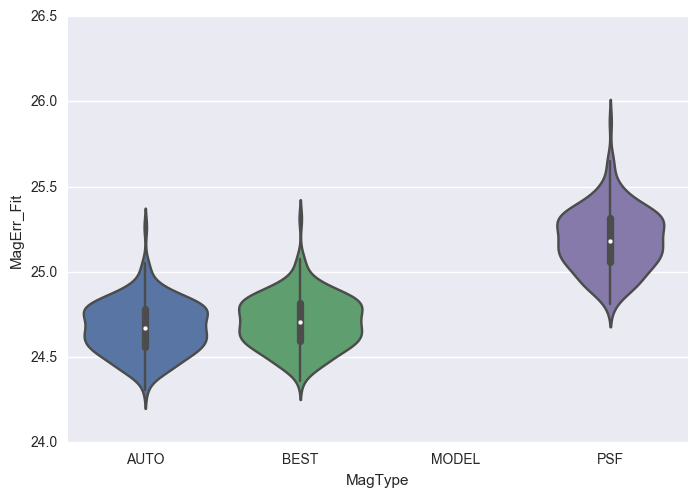

In [28]:
import seaborn
ax = seaborn.violinplot(x='MagType',y='MagErr_Fit',data=bla)
fig = ax.figure

from IPython.display import display
display(fig)
plt.cla()
plt.clf()

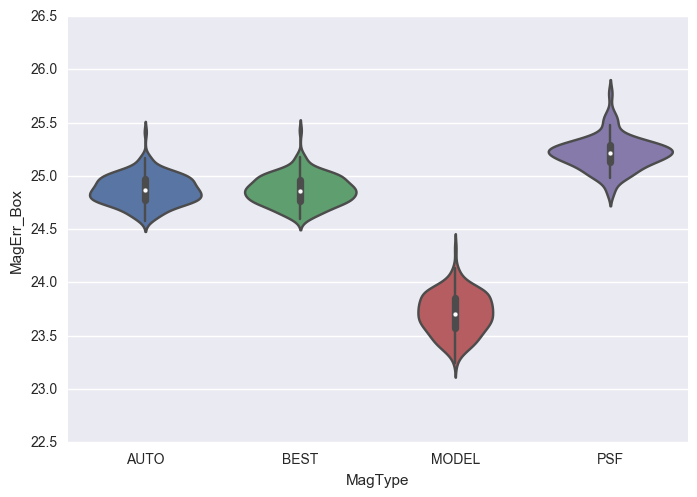

In [29]:
import seaborn
ax = seaborn.violinplot(x='MagType',y='MagErr_Box',data=bla)
fig = ax.figure

from IPython.display import display
display(fig)
plt.cla()
plt.clf()

In [39]:
for gn,grp in df.groupby('MagType'):
    print '-'*5,"\n",gn,"\n",grp.describe(),"\n"

----- 
AUTO 
       MagErr_Box  MagErr_Fit
count  165.000000  165.000000
mean    24.870146   24.673930
std      0.136120    0.152658
min     24.576779   24.308902
25%     24.770534   24.561648
50%     24.866433   24.668562
75%     24.967486   24.784478
max     25.413723   25.263375 

----- 
BEST 
       MagErr_Box  MagErr_Fit
count  165.000000  165.000000
mean    24.867954   24.707415
std      0.136537    0.152981
min     24.592882   24.361165
25%     24.767189   24.596450
50%     24.857832   24.704751
75%     24.963690   24.819707
max     25.428718   25.312833 

----- 
MODEL 
       MagErr_Box  MagErr_Fit
count  165.000000         0.0
mean    23.707572         NaN
std      0.190859         NaN
min     23.248725         NaN
25%     23.568828         NaN
50%     23.706999         NaN
75%     23.854605         NaN
max     24.320285         NaN 

----- 
PSF 
       MagErr_Box  MagErr_Fit
count   76.000000  165.000000
mean    25.214361   25.189428
std      0.153655    0.182037
min     24.8